In [1]:
import numpy as np 
import igraph as ig
import leidenalg as la
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import normalized_mutual_info_score

iter = 2
data_number = 10

data_path = f'dataset/TC1-{data_number}/1-{data_number}.dat'
label_path = f'dataset/TC1-{data_number}/1-{data_number}-c.dat'

data = np.loadtxt(data_path).astype(int)
graph = ig.Graph(data, directed=False)
partition = la.find_partition(graph, la.ModularityVertexPartition, n_iterations=iter, seed=7777,)

vertices = graph.vcount() - 1

answer = pd.read_csv(label_path, sep='\t', header=None)
labels = answer[1].values

print(f"{len(partition)} clusters found")
print(f"Number of vertexes: {vertices}")

17 clusters found
Number of vertexes: 10001


In [2]:
pred_labels = [0] * (vertices - 1)
for id, nodes in enumerate(partition):
    for node in nodes:
        if node != 0:
            pred_labels[node - 1] = id

pred_labels = np.array(pred_labels)
original_nmi = normalized_mutual_info_score(answer[1], pred_labels)

original_modularity = partition.modularity
print(f"Original NMI: {original_nmi}")
print(f"Original modularity: {original_modularity}")

Original NMI: 0.12678448772894274
Original modularity: 0.21181441655483504


In [3]:
cluster_set = []

n_of_valid_vertices = 0
mother_modularity = original_modularity
for cluster_index, cluster_vertices in tqdm(enumerate(partition), total=len(partition)):
    new_graph = []
    for index in range(len(data)):
        node1, node2 = data[index]
        # assert node1 != node2
        if node1 in cluster_vertices and node2 in cluster_vertices:
            new_graph.append([node1, node2])

    new_graph = np.array(new_graph)
    unique_nodes, count = np.unique(new_graph, return_counts=True)
    
    # Mapping
    old2new = {}
    new2old = {}
    for i, node in enumerate(unique_nodes):
        old2new[node] = i
        new2old[i] = node
        
    new_vertices = np.array([[old2new[node1], old2new[node2]] for node1, node2 in new_graph])
    if len(new_vertices) == 0:
        print(f'{cluster_index} is empty')
        print(f"Vertices: {len(cluster_vertices)}, {cluster_vertices}")
        # cluster_set.append(cluster_vertices)
        continue
        
    # Generate sub-graphs
    new_graph = ig.Graph(new_vertices, directed=False)
    sub_partition = la.find_partition(new_graph, la.ModularityVertexPartition, n_iterations=iter, seed=7777)
    if sub_partition.modularity < mother_modularity:
        cluster_set.append(cluster_vertices)
        continue
    n_of_valid_vertices += len(cluster_vertices)

    # if len(unique_nodes) != len(cluster_vertices):
    #     print(list(unique_nodes))
    #     print(cluster_vertices)

    check_assert_list = []
    for index, sub_vertices in enumerate(sub_partition):
        old_sub_vertices = []
        for new_vertex in sub_vertices:
            old_sub_vertices.append(new2old[new_vertex])
        check_assert_list.extend(old_sub_vertices)
        if len(old_sub_vertices) != 0:
            cluster_set.append(old_sub_vertices)
    print(f"Cluster {cluster_index} has been divided into {len(sub_partition)} clusters")
    #     assert len(old_sub_vertices) != 0
    
    # check_assert = False
    # assert len(check_assert_list) == len(list(old2new.keys()))
    # for node1, node2 in zip(sorted(check_assert_list), sorted(list(old2new.keys()))):
    #     assert node1 == node2
        

  6%|▌         | 1/17 [00:07<01:58,  7.41s/it]

Cluster 0 has been divided into 15 clusters


 12%|█▏        | 2/17 [00:11<01:24,  5.66s/it]

Cluster 1 has been divided into 16 clusters


 18%|█▊        | 3/17 [00:16<01:09,  4.98s/it]

Cluster 2 has been divided into 16 clusters


 24%|██▎       | 4/17 [00:19<00:58,  4.53s/it]

Cluster 3 has been divided into 16 clusters


 29%|██▉       | 5/17 [00:23<00:49,  4.12s/it]

Cluster 4 has been divided into 16 clusters


 35%|███▌      | 6/17 [00:25<00:39,  3.62s/it]

Cluster 5 has been divided into 15 clusters


 41%|████      | 7/17 [00:28<00:32,  3.26s/it]

Cluster 6 has been divided into 14 clusters


 47%|████▋     | 8/17 [00:30<00:25,  2.88s/it]

Cluster 7 has been divided into 15 clusters


 53%|█████▎    | 9/17 [00:31<00:19,  2.45s/it]

Cluster 8 has been divided into 14 clusters


 59%|█████▉    | 10/17 [00:33<00:15,  2.15s/it]

Cluster 9 has been divided into 14 clusters


 65%|██████▍   | 11/17 [00:34<00:11,  1.95s/it]

Cluster 10 has been divided into 15 clusters


 71%|███████   | 12/17 [00:36<00:08,  1.73s/it]

Cluster 11 has been divided into 13 clusters


 76%|███████▋  | 13/17 [00:37<00:06,  1.53s/it]

Cluster 12 has been divided into 17 clusters


 82%|████████▏ | 14/17 [00:38<00:04,  1.39s/it]

Cluster 13 has been divided into 15 clusters


 88%|████████▊ | 15/17 [00:38<00:02,  1.16s/it]

Cluster 14 has been divided into 10 clusters


100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

Cluster 15 has been divided into 10 clusters
16 is empty
Vertices: 1, [0]


In [4]:
print(f"Found clusters: {len(cluster_set)}")
total_nodes = 0
for index, cluster in enumerate(cluster_set):
    total_nodes += len(cluster)
print(f"Total nodes: {total_nodes}")

Found clusters: 231
Total nodes: 10000


<BarContainer object of 203 artists>

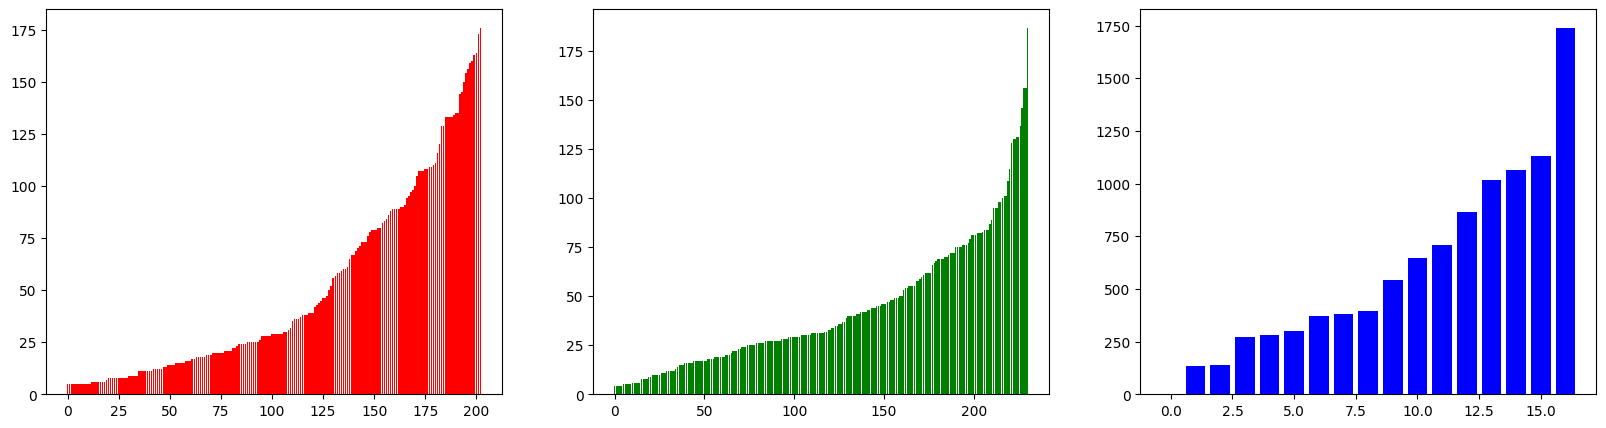

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
counts = sorted([len(cluster) for cluster in partition])
axes[2].bar(range(len(counts)), counts, color='b')

counts = sorted([len(cluster) for cluster in cluster_set])
axes[1].bar(range(len(counts)), counts, color='g')

unique, counts = np.unique(labels, return_counts=True)
counts = sorted(counts)
axes[0].bar(range(len(counts)), counts, color='r')



In [7]:
pred_labels = [0] * (vertices - 1)
for id, nodes in enumerate(cluster_set):
    for node in nodes:
        if node != 0:
            pred_labels[node - 1] = id

pred_labels = np.array(pred_labels)
sub_nmi = normalized_mutual_info_score(answer[1], pred_labels)
print(f"Data number: {data_number}")
print(f"Ori NMI: {original_nmi}")
print(f"Sub NMI: {sub_nmi}")

print("Improvement: ", sub_nmi - original_nmi, "Percentage: ", (sub_nmi - original_nmi) / original_nmi * 100)
print(f"Original modularity: {original_modularity}")

Data number: 10
Ori NMI: 0.12678448772894274
Sub NMI: 0.3672048193478946
Improvement:  0.24042033161895188 Percentage:  189.6291383319349
Original modularity: 0.21181441655483504
